# Chapter 3: Journey to the Frozen Sea

In this notebook we will focus on sea ice and its obvious signs of a changing climate. To this end, we will use satellite data to investigate different characteristics of sea ice in the Arctic and Antarctic.

<div class="alert alert-block alert-success">
<b>Objective</b> <br>
    Reproduce figures from the <a href="https://climate.copernicus.eu/climate-intelligence">C3S Climate Intelligence</a> reports about sea ice. Specifically, we will reproduce figures from the sea ice section of the <a href="https://climate.copernicus.eu/climate-bulletins">Monthly Climate Bulletins</a> and <a href="https://climate.copernicus.eu/climate-indicators/sea-ice">Climate Indicators</a>.
 </a>
</div>


### Background

The data we're going to analyze is provided by the European Organisation for the Exploitation of Meteorological Satellites (<a href="https://www.eumetsat.int/">EUMETSAT</a>). It's a global operational satellite agency at the heart of Europe that provides data, products, and support to a wide range of users in Europe and across the world.

The <a href="https://osi-saf.eumetsat.int/">OSI SAF</a>, or Ocean and Sea Ice Satellite Application Facility, is one of the specialized Satellite Application Facilities (SAFs) under EUMETSAT. The SAFs are dedicated centers of excellence for processing satellite data, and they focus on various thematic areas. OSI SAF, as its name suggests, concentrates on delivering operational products and services related to ocean and [sea ice](https://osi-saf.eumetsat.int/products/sea-ice-products).

In this tutorial we will work with different characteristics of global sea ice, specifically we will look at
* **Sea Ice Concentration (SIC)** is the fractional coverage of a grid cell that is covered with sea ice
* **Sea Ice Extent (SIE)** is the total area of all grid cells with at least 15% ice concentration.
* **Sea Ice Area** is the total area covered with sea ice. It is obtained by multiplying grid cell areas by their corresponding sea ice concentration and summing up the results.
* **Sea Ice Edge**:  The sea surface can be classified into open water, open ice, and closed ice depending on the amount of sea ice present in each grid cell. A sea ice concentration threshold of 30% is used to distinguish between open water and open ice.
* **Sea Ice Type**: Sea ice-covered areas are typically distinghuised by two categories based on the age of the sea ice: multiyear ice versus seasonal first-year ice.

### Overview Datasets

Most of the datasets are provided by the [MET Norway Thredds Service](https://thredds.met.no/thredds/osisaf/osisaf.html) of the Norwegian Meteorological Institute and some are made available through the Climate Data Store (CDS). Once exception is the Sea Ice Index, which indicates sea ice extent in both the Arctic and Antarctic,and which is only providede by OSI SAF. In contrast, the C3S provides a special product dedicated to the sea ice edge and type which is only available through the CDS.

Throughout the notebook we will use the following datasets:

| Variable | Provider | MET Norway Thredds Service | Climate Data Store |
|---------|:-------------:|:------:|:------:|  
| Sea ice concentration | EUMETSAT OSI SAF | [CDR v3.0](https://osi-saf.eumetsat.int/products/osi-430-a) (OSI-450-a) / [ICDR v3.0](https://osi-saf.eumetsat.int/products/osi-450-a) (OSI-430-a) | [Yes](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-concentration?tab=overview) |
| Sea ice extent | EUMETSAT OSI SAF | [Sea Ice Index v2.2](https://osi-saf.eumetsat.int/products/osi-420) | -- |
| Sea ice edge/type | C3S/CDS | -- | [Yes](https://doi.org/10.24381/cds.29c46d83)


<div class="alert alert-block alert-warning">
<b>Warning</b>: <br>
    This notebook is rather data intensive and requires ~100 GB free disk space. Notebook cells that trigger a download are marked with a warning sign.
</div>

<style>
td, th {
   border: 1px solid white;
   border-collapse: collapse;
}
</style>
<table align="left">
  <tr>
    <th>Run the tutorial via free cloud platforms: </th>
    <th><a href="https://mybinder.org/v2/gh/ECMWFCode4Earth/sketchbook-earth/main?labpath=tutorials/03_sea_ice/03_sea_ice.ipynb">
        <img src = "https://mybinder.org/badge.svg" alt = "Binder"></th>
    <th><a href="https://kaggle.com/kernels/welcome?src=https://github.com/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/03_sea_ice/03_sea_ice.ipynb">
        <img src = "https://kaggle.com/static/images/open-in-kaggle.svg" alt = "Kaggle"></th>
    <th><a href="https://colab.research.google.com/github/ECMWFCode4Earth/sketchbook-earth/blob/main/tutorials/03_sea_ice/03_sea_ice.ipynb">
        <img src = "https://colab.research.google.com/assets/colab-badge.svg" alt = "Colab"></th>
  </tr>
</table>

-----------

### Import Packages

In [2]:
import os
import glob
import cdsapi
import xarray as xr
import numpy as np
from tqdm.notebook import tqdm

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import seaborn as sns
import cmocean as cmo

import dask

import matplotlib.dates as dates
import matplotlib.ticker as ticker
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
import seaborn as sns

from cartopy.mpl.ticker import LatitudeFormatter, LongitudeFormatter
import matplotlib.path as mpath
from matplotlib.gridspec import GridSpec
from dask.diagnostics.progress import ProgressBar

Use the following cell to activate this book's visualization style for consistent plots throughout the notebook. Note that this cell impacts only the visualization and does not affect the computation in this notebook and thus can be skipped. Also note that the matplotlib stylesheet won't be available when running the notebook on GoogleColab.

In [3]:
plt.style.use("../copernicus.mplstyle")

Avoid the creation of large dask chunks to improve [dask performance](https://docs.dask.org/en/latest/understanding-performance.html):

In [4]:
dask.config.set(**{'array.slicing.split_large_chunks': True})

### Getting Set Up

Set the reference period that defines the climatology of our records. Since we will be working with different data that comes with a time coordinate based on either daily `datetime` or annual `int` values representing years, we will define the reference period for both cases:

In [5]:
REF_PERIOD_YEARS = {'year': slice(1991, 2020)}
REF_PERIOD_DATETIME = {'time': slice('1991-01-01', '2020-12-31')}

Let's again create a data directory to manage our data files:

In [6]:
path_to = {}  # dictionary containing [<variable> : <target folder>]

path_to.update({"ice_conc": "data/concentration/"})
path_to.update({"ice_conc_processed": "data/concentration/processed/"})
path_to.update({"ice_extent": "data/extent/"})
path_to.update({"ice_edge": "data/edge/"})
path_to.update({"ice_type": "data/type/"})

for file, path in path_to.items():
    os.makedirs(os.path.dirname(path), exist_ok=True)
    print("{:<20} --> {}".format(file, path))

ice_conc             --> data/concentration/
ice_conc_processed   --> data/concentration/processed/
ice_extent           --> data/extent/
ice_edge             --> data/edge/
ice_type             --> data/type/


### Sea Ice Concentration
We start with downloading and analysing sea ice concentration as it forms the basis from which the other sea ice variables like extent, area and edge can be derived from. Our first goal will be to visualize the sea ice extent anomalies for a given month. To save up on data, we will start by focusing on the Arctic. However, we will also show how to circumvent the intensive data crunching specifically for sea ice extent by using the OSI SAF Sea Ice Index, allowing us to visualize the recent changes in the Antarctic as well. 

#### Downloading from CDS
Sea ice concentration (SIC) is available through the [CDS](https://doi.org/10.24381/cds.3cd8b812) as a daily gridded data set from 1979 to present. Since the entire data set is rather large, we will download only some specific months necesarry for the reproduction of the C3S Climate Intelligence reports. Specifically, we will need the months of January to March and September. We will download the data using the CDS API and store it in the data directory we created above. For the sake of download efficiency, we will batch the download for each month.

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    As the time of writing, the Climate Data Store provides access to version 2 of the dataset and not the most recent version 3. If you need version 3, please consider downloading directly from <a href="https://osi-saf.eumetsat.int/products/osi-430-a">EUMETSAT OSI SAF official webpage</a>.
</div>


In the following cell, we will define a function that accepts a CDS `Client` object, together with a year and month to be downloaded and a path to which the file should be saved. Since the data is provided in `tgz` format, we will have to untar the file after downloading it. The last line of the method will also remove the tar file after untarring it to save up on disk space.

In [7]:
DAYS = ["{:02d}".format(d) for d in range(1, 32)]

def download_sea_ice_concentration(client, year, month, save_to):
    client.retrieve(
        "satellite-sea-ice-concentration",
        {
            "version": "v2",
            "variable": "all",
            "format": "tgz",
            "origin": "eumetsat_osi_saf",
            "region": "northern_hemisphere",
            "cdr_type": ["cdr", "icdr"],
            "year": year,
            "month": month,
            "day": DAYS,
        },
        save_to,
    )
    # Untar and then remove tar file
    path_dir = os.path.dirname(save_to)
    os.system(f"tar -xzf {save_to} --directory {path_dir}")
    os.system(f"rm {save_to}")


To download the data via the `cdsapi`, we'll have to provide our CDS API key:

In [419]:
URL = 'https://cds.climate.copernicus.eu/api/v2'
KEY = '##################################' # add your key here the format should be as {uid}:{api-key}

<div class="alert alert-block alert-info">
<b>New to CDS?</b> Consider the <a href="https://ecmwf-projects.github.io/copernicus-training-c3s/cds-tutorial.html">CDS tutorial</a> for a detailed guide.
</div>

Then we can initialize the CDS client. Note that we surpress the quite verbose `cdsapi` output by setting the `quiet` and `progress` parameters to accordingly and will make use of `tqdm` to track the overall download progress.

In [407]:
client = cdsapi.Client(url=URL, key=KEY, quiet=True, progress=False)

Additionally, we'll have to define the years and months that we want to download. We will download the months of January to March and September for the years 1979 to 2022.

In [8]:
YEARS = ["{:04d}".format(y) for y in range(1979, 2023)]
MONTHS = ["{:02d}".format(m) for m in [1, 2, 3, 9]]  # Note: only Jan, Feb, Mar and Sep are downloaded

Now let's loop through our years and months and download the data. We will store the downloaded files in the `data` directory we created above. In case you have to stop the download for some reason, you can simply re-run the cell and it will skip already downloaded files.

<div class="alert alert-block alert-warning">
<b>Warning</b>: <br>
    The following cell will download about 40 GB. Please be sure that you have enough space available. Depending on your broadband internet connection this may take up to several hours.
</div>

In [ ]:
for year in tqdm(YEARS, desc="Overall progress"):
    for month in tqdm(MONTHS, desc="Year {}".format(year), leave=False):
        # Define the filename and the path to save the file
        filename = f"EUMETSAT_OSI_SAF_SIC_{year}_{month}.tar.gz"
        save_to = os.path.join(path_to["concentration"], filename)
        # Check if the extracted files already exist
        files_in_dir = glob.glob(f"data/concentration/*{year}{month}*.nc")
        skip_file = len(files_in_dir) > 0
        # Download the file only if it doesn"t exist
        if not skip_file:
            download_sea_ice_concentration(client, year, month, save_to)

#### Lazy Loading

Let's quickly inspect one of the downloaded files.

In [9]:
da = xr.open_dataset("data/concentration/ice_conc_nh_ease2-250_icdr-v2p0_202209301200.nc")
da

<xarray.Dataset>
Dimensions:                   (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                      (time) datetime64[ns] 2022-09-30T12:00:00
  * xc                        (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                        (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                       (yc, xc) float32 ...
    lon                       (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid    int32 ...
    time_bnds                 (time, nv) datetime64[ns] ...
    ice_conc                  (time, yc, xc) float64 ...
    raw_ice_conc_values       (time, yc, xc) float64 ...
    total_standard_error      (time, yc, xc) float64 ...
    smearing_standard_error   (time, yc, xc) float64 ...
    algorithm_standard_error  (time, yc, xc) float64 ...
    status_flag               (time, yc, xc) float32 ...
Attributes: (12/41)
    title:                     Interim Sea Ice Concentration Climate Data Rec...
    summary:                   This Interim Climate Data Record implements an...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  Earth Science > Cryosphere > Sea Ice > Sea Ice...
    keywords_vocabulary:       GCMD Science Keywords
    geospatial_lat_min:        16.62393
    ...                        ...
    tracking_id:               40d1b998-ea2b-4d1e-b761-0b501e06448c
    Conventions:               CF-1.7 ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (v65, 09 April 2019)
    product_id:                osi-430-b
    product_name:              osi_saf_sea_ice_conc_climate_data_record_interim
    product_status:            demonstration

We see that the file is very comprehensive, containing not only the sea ice concentration but also other variables linked to the preprocessing, uncertainty and quality of the data. For our purposes, we will only need the `ice_conc` variable which is the our variable of interest. 

In addition, note that the spatial data coordinates are represented as `xc` and `yc`, which together can be combined to `lat` and `lon`. The difference between both is that while `xc` and `yc` represent grid cells of a fixed size (25 km as stated in the CDS data overview) within a Lambert Azimuthal Equal Area projection, the latitude and longitude system does not preserve grid cell area. As we will see, the `xc` and `yc` coordinates are more convenient to work with (e.g. to compute sea ice extent), so we will keep them and remove the `lat` and `lon` coordinates to save up on memory.

Now, let's load the data into an `xr.Dataset` object. We will use the `xr.open_mfdataset` method to open all the downloaded files at once. This method will automatically combine the files into a single `xr.Dataset` object, but -- importantly -- without loading the data into the memory. Instead, the data will be loaded lazily, meaning that it will only be loaded into the memory when it is actually needed. This is a very convenient feature of `xarray` that allows us to work with large datasets without having to worry about memory issues.

To speed up the lazy loading process, we will make use of a `preprocess` function, that can be provided to the `open_mfdataset` methods, which allows us to remove the `lat` and `lon` coordinates and select only the `ice_conc` variable before the individual files are combined.

In [10]:
def return_sic_only(ds):
    ds = ds.drop_vars(["lat", "lon"])
    return ds['ice_conc']

Now, we're ready to load the data. Note that this can take up to some minutes.

In [11]:
sic = xr.open_mfdataset(path_to['ice_conc'] + "/*.nc", preprocess=return_sic_only)
sic

<xarray.Dataset>
Dimensions:   (time: 3735, xc: 432, yc: 432)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-09-30T12:00:00
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Data variables:
    ice_conc  (time, yc, xc) float64 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>

#### Preprocessing

One important aspect for deriving the sea ice extent anomalies for a specfic month is the convertion from a daily to a monthly product. As stated in the [About the Data](https://climate.copernicus.eu/climate-indicators/about-data#Seaiceindicator) section of the C3S Climate Indicators, the monthly sea ice concentration is computed as the average of the daily sea ice concentration values for each grid cell. However, since the data are only available every other day during the period when observations from the SMMR sensor are used, the gridded data are first linearly interpolated in time, before monthly averages are computed.

The following function will create a daily index for a given `Dataset` object, reindex the data to the daily index and then interpolate the data linearly in time. The resulting `Dataset` object will then contain daily sea ice concentration values for each grid cell. Note that we will only interpolate the data for the month of September, as described in the *About the Data* section above.



In [19]:
def interpolate_daily(da):
    months = np.unique(da.time.dt.month)
    # Create a daily time index
    daily_index = xr.date_range(start=da.time[0].values,end=da.time[-1].values, freq='D')
    # Only consider the months that are in the data
    daily_index = daily_index[daily_index.month.isin(months)]
    # Reindex the data to the daily time index
    da_reindexed = da.reindex(time=daily_index)
    # Rechunk the data in space to speed up the interpolation
    da_reindexed = da_reindexed.chunk(dict(time=-1, xc=50, yc=50))
    # Interpolate the missing values
    return da_reindexed.interpolate_na("time")

is_september = sic.time.dt.month == 9
sic_september = sic.sel(time=is_september)
sic_interp = interpolate_daily(sic_september)
sic_interp["ice_conc"]

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)
/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.DataArray 'ice_conc' (time: 1320, yc: 432, xc: 432)>
dask.array<transpose, shape=(1320, 432, 432), dtype=float64, chunksize=(1320, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-09-01T12:00:00 ... 2022-09-30T12:00:00
  * xc       (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Attributes:
    long_name:            fully filtered concentration of sea ice using atmos...
    standard_name:        sea_ice_area_fraction
    units:                %
    valid_min:            0
    valid_max:            10000
    grid_mapping:         Lambert_Azimuthal_Grid
    ancillary_variables:  total_standard_error status_flag
    comment:              this field is the primary sea ice concentration est...

The great advantage of `dask` is that we can chain several operations until we know that our processed data set is small enough to fit into memory and which we can then compute and load. However, repeatedly computing the same dask DataArray several times can lead to very long computing times. So let's compute this intermediate result and save it to the disk, from where we can (laizily) load it again for further processing.

In [20]:
path_to_processed_sic = path_to['ice_conc_processed'] + "ice_conc_interpolated.nc"

with ProgressBar():
    sic_interp.to_netcdf(path_to_processed_sic)

[########################################] | 100% Completed | 83.31 s


Let's reload the data set, again as a dask DataArray. However, since we'll have to perform operations in the spatial dimensions when computing the sea ice extent (computing the sum of grid cells covered with ice), we want to create chunks along the time domain so that each loaded chunk of data has the entire information availalbe necessary for the computation. By specifying the chunks of a dimensions as $-1$, we signal that we don't want to chunk along that dimension.

In [22]:
chunks = dict(time=50, xc=-1, yc=-1)
with xr.open_mfdataset(path_to_processed_sic, chunks=chunks) as sic_interp:
    pass

### Sea Ice Extent

As explained briefly in the introduction, the sea ice extent is the total area covered by sea ice for any given moment, where a grid cell is assumed to be covered with ice if the sea ice concentration is equal to or above 15 %. From the overview page in the CDS, we know that the data product is represented on a Lambert Azimuthal Equal Area projection centred over the poles, with a 25 km grid resolution. Let's quickly double check this by inspecting the coordinates of the data set, e.g. by looking at the step size of the `xc` and `yc` coordiante:

In [23]:
print(sic_interp.coords['xc'].diff('xc').values[:5])
print(sic_interp.coords['yc'].diff('yc').values[:5])

[25. 25. 25. 25. 25.]
[-25. -25. -25. -25. -25.]


As expected, the step size is 25 (km) for both coordinates. Consequentely, each grid cell represents an area of $25^2 \text{km}^2= 625 \text{km}^2$. The sea ice extent is therefore given by multiplying this area with the number of ice-covered grid cell:

In [24]:
is_covered = sic_interp['ice_conc'] >= 15
ice_extent = (is_covered * 25**2).sum(('yc', 'xc'))
ice_extent

<xarray.DataArray 'ice_conc' (time: 1320)>
dask.array<sum-aggregate, shape=(1320,), dtype=int64, chunksize=(50,), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-09-01T12:00:00 ... 2022-09-30T12:00:00

This time series is small to fit easily into memory, so let's compute it!

In [25]:
with ProgressBar():
    ice_extent = ice_extent.compute()
    


[########################################] | 100% Completed | 2.07 sms


Based on the daily values, we can compute monthly averages:

In [26]:
ice_extent_monthly = ice_extent.resample(time='1M').mean()

In order to compute anomalies, we will first have to compute the reference climatology.

In [27]:
ice_extent_monthly_clim = ice_extent_monthly.sel(REF_PERIOD_DATETIME).mean('time')
ice_extent_monthly_anomaly = ice_extent_monthly - ice_extent_monthly_clim

The relative monthly anomaly of sea ice extent -- as shown in the Figure 1 of both Monthly Climate Bulletins and Climate Indicator -- is then computed as follows:

In [28]:

ice_extent_monthly_anomaly_relative = ice_extent_monthly_anomaly / ice_extent_monthly_clim * 100 # in percent

For visualizing, let's create shorter handles:

In [29]:
time_steps = ice_extent_monthly_anomaly_relative.time
data = ice_extent_monthly_anomaly_relative

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


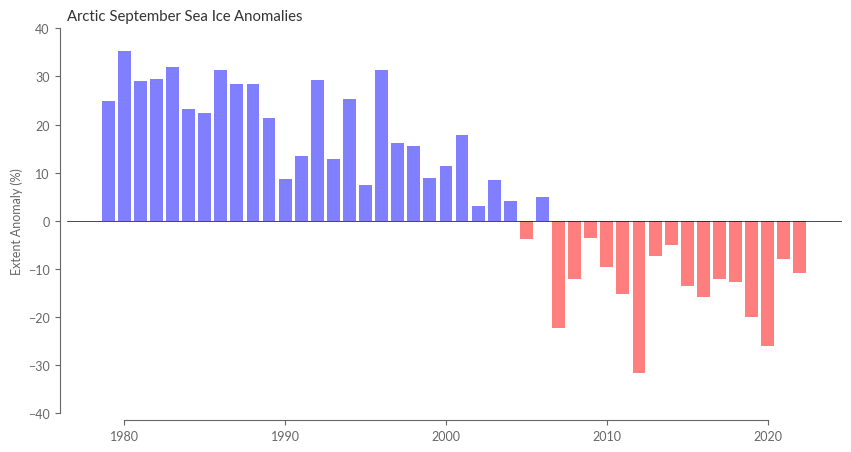

In [30]:
# define colors to be blue for positive and red for negative anomalies
colors = ['blue' if x >= 0 else 'red' for x in data]
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
ax.bar(data.time.dt.year, data, color=colors, alpha=.5)
ax.axhline(0, color='black', linewidth=.5)
ax.set_title('Arctic September Sea Ice Anomalies')
ax.set_ylabel('Extent Anomaly (%)')
ax.set_ylim(-40, 40)
sns.despine(ax=ax, offset=5, trim=True)
plt.show()

### Sea Ice Extent (less data chrunchy alternative)

In the previous section we showed how to derive the sea ice extent for the Arctic based on the sea ice concentration. While the computation is straight-forward, it requires large amounts of data which can be a burden for some users. To circumvent this, the OSI SAF provides a dedicated product for sea ice extent, the [Sea Ice Index](https://osi-saf.eumetsat.int/products/osi-420). The Sea Ice Index provides daily sea ice extent for both the Arctic and Antarctic, which is computed from the sea ice concentration data. The advantage of this product is that it is already pre-computed and thus requires less data crunching.

To retrieve the sea ice index, we will use the [MET Norway Thredds Service](https://thredds.met.no/thredds/osisaf/osisaf.html) of the Norwegian Meteorological Institute. The data is provided in `netCDF` format and can be downloaded directly from the [Thredds server](https://thredds.met.no/thredds/osisaf/osisaf_seaiceindex.html). In particular, we can use the following links to download the index for [Northern Hemisphere](https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/index/v2p2/nh/catalog.html?dataset=osisaf/met.no/ice/index/v2p2/nh/osisaf_nh_sie_daily.nc) and [Southern Hemisphere](https://thredds.met.no/thredds/catalog/osisaf/met.no/ice/index/v2p2/sh/catalog.html?dataset=osisaf/met.no/ice/index/v2p2/sh/osisaf_sh_sie_daily.nc).

In [31]:
url_northern_hemisphere = "https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/index/v2p2/nh/osisaf_nh_sie_daily.nc"
url_southern_hemisphere = "https://thredds.met.no/thredds/dodsC/osisaf/met.no/ice/index/v2p2/sh/osisaf_sh_sie_daily.nc" 

sie_nh = xr.open_dataset(url_northern_hemisphere)
sie_sh = xr.open_dataset(url_southern_hemisphere)
sie_nh

<xarray.Dataset>
Dimensions:        (time: 16388, nv: 2)
Coordinates:
  * time           (time) datetime64[ns] 1978-10-25 1978-10-26 ... 2023-09-06
    sic_threshold  float32 ...
    lat            float32 ...
    lon            float32 ...
Dimensions without coordinates: nv
Data variables:
    lat_bounds     (nv) float32 ...
    lon_bounds     (nv) float32 ...
    area           |S64 ...
    sie            (time) float64 ...
    source         (time) float64 ...
Attributes: (12/35)
    title:                   Daily Northern Hemisphere Sea Ice Extent from EU...
    product_id:              OSI-420
    product_name:            OSI SAF Sea Ice Index
    product_status:          demonstration
    version:                 v2p2
    summary:                 Time series of Daily Sea Ice Extent (SIE) for No...
    ...                      ...
    distribution_statement:  Free
    copyright_statement:     Copyright 2023 EUMETSAT
    references:              Product User Manual for OSI-420, Lavergne et al....
    featureType:             timeSeries
    DODS.strlen:             2
    DODS.dimName:            nchar

Let's clean up the data sets first,

In [32]:
sie_nh = sie_nh.drop_vars(["lat", "lon", "sic_threshold"])
sie_sh = sie_sh.drop_vars(["lat", "lon", "sic_threshold"])

then combine them into Dataset containing two variables, one for the `Arctic` and one for the `Antarctic`.

In [33]:
sie = xr.Dataset({
    "Arctic": sie_nh["sie"],
    "Antarctic": sie_sh["sie"],
})
sie

<xarray.Dataset>
Dimensions:    (time: 16388)
Coordinates:
  * time       (time) datetime64[ns] 1978-10-25 1978-10-26 ... 2023-09-06
Data variables:
    Arctic     (time) float64 ...
    Antarctic  (time) float64 ...

Let's have a quick look at the data:

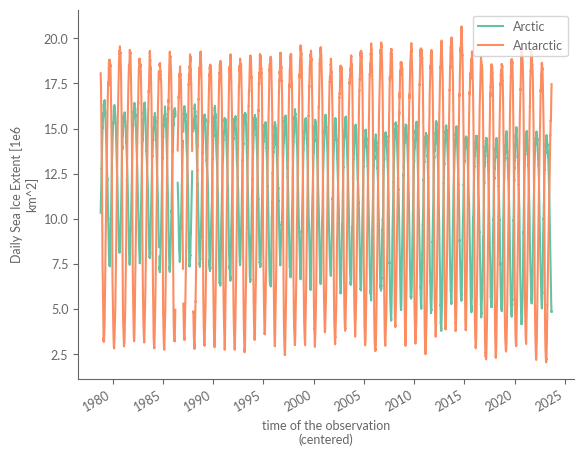

In [34]:
sie["Arctic"].plot(label="Arctic")
sie["Antarctic"].plot(label="Antarctic")
plt.legend()

We see that in contrast to our own derivation, which required more data to be processed and only provided as with the daily sea ice extent for September in the Arctic, this alternative approach allows us to analyze daily data for both hemispheres throught the entire year. In addition, this data set is updated regularly with a time lag of only a couple of days, lending itself as a vital data source for inspecting recent developments in global sea ice extent.

In the following, we want to visualise daily values of sea ice extent in a line plot. For this purpose, we rearange the data coordiantes, converting the `time` dimension into two new dimensions, `year` and `dayofyear`. 

In [35]:
sie["year"] = sie.time.dt.year
sie["dayofyear"] = sie.time.dt.dayofyear
sie = sie.set_index(time=["year", "dayofyear"]).unstack()
sie


/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


<xarray.Dataset>
Dimensions:    (year: 46, dayofyear: 366)
Coordinates:
  * year       (year) int64 1978 1979 1980 1981 1982 ... 2020 2021 2022 2023
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Data variables:
    Arctic     (year, dayofyear) float64 nan nan nan nan nan ... nan nan nan nan
    Antarctic  (year, dayofyear) float64 nan nan nan nan nan ... nan nan nan nan

In order to visualise the data, we will make use of some helper functions:

- `create_line_plot`: create the basic plot, i.e. objects for `Figure` and `Axes`, as well as the basic plot representing one year per line
- `highlight_most_recent_year`: as the name suggest, this function will highlight the most recent year (line) for a given data set, by changing its color and adding a marker at its end to indicate the latest data point
- `center_labels_between_xticks`: this function really just improves the look of the figure by moving the axis label for each month between the ticks. This function is based on the instructions [here](https://matplotlib.org/stable/gallery/ticks/centered_ticklabels.html)

In [37]:
def create_line_plot(data):
    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111)
    # Plot the data as a line for each year
    xr.plot.line(data, ax=ax, x="dayofyear", color=".5", alpha=.5, add_legend=False)
    return fig, ax

def highlight_most_recent_year(ax, data):
    # Add the most recent year as a red line
    data.isel(year=-1).plot.line(ax=ax, x="dayofyear", color="r", alpha=.5, lw=4)
    # Add text with year at the most recent data point with the same color as the line
    most_recent_data = data.isel(year=-1).dropna('dayofyear').isel(dayofyear=-1)
    ax.text(
        most_recent_data.dayofyear + 5,
        most_recent_data.values,
        most_recent_data.year.values,
        color="r",
        alpha=.5,
        fontsize=14,
        weight="bold",
        va="center",
    )
    # Mark the most recent data with a red circle
    ax.plot(
        most_recent_data.dayofyear,
        most_recent_data.values,
        "o",
        color="r",
        alpha=.75,
        markersize=10,
        markeredgewidth=0,
    )

def center_labels_between_xticks(ax):
    # set y-ticks as integers
    ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))

    # Set major x-ticks every 1 month
    ax.xaxis.set_major_locator(dates.MonthLocator())


    # Centering labels between ticks
    # 16 is a slight approximation since months differ in number of days.
    ax.xaxis.set_minor_locator(dates.MonthLocator(bymonthday=16))
    ax.xaxis.set_major_formatter(ticker.NullFormatter())
    ax.xaxis.set_minor_formatter(dates.DateFormatter("%b"))

    # Remove the minor tick lines
    ax.tick_params(axis="x", which="minor", tick1On=False, tick2On=False)

    # Align the minor tick label
    for label in ax.get_xticklabels(minor=True):
        label.set_horizontalalignment("center")

Select the hemisphere  for which the data is to be plotted:

In [38]:
region = 'Antarctic'

Now, let's plot!

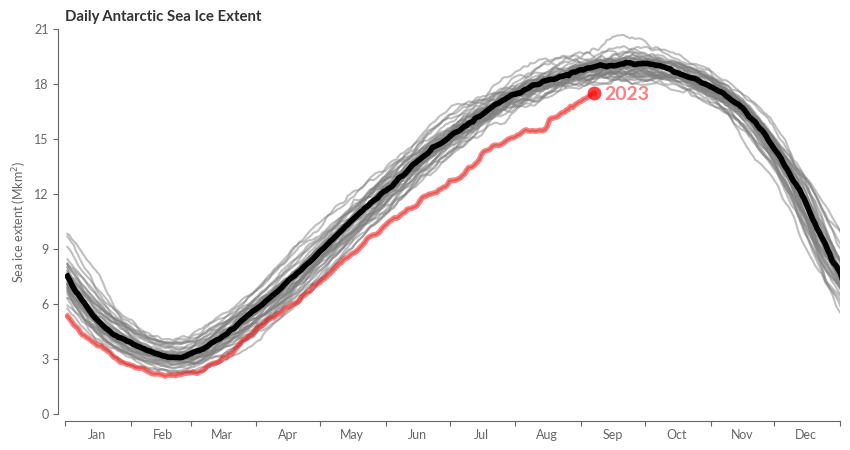

In [39]:
fig, ax = create_line_plot(sie[region])
# Add the median as a bold black line
sie_clim_median[region].plot(ax=ax, color="k", alpha=1, lw=4)
highlight_most_recent_year(ax, sie[region])
center_labels_between_xticks(ax)
ax.set_xlim(0, 365)
ax.set_ylim(0, 21)
ax.set_xlabel("")
ax.set_title(f"Daily {region} Sea Ice Extent", weight='bold')
ax.set_ylabel("Sea ice extent (Mkm$^2$)")
sns.despine(ax=ax, trim=False, offset=5)
plt.show()

We proceed with visualising the anomalies, for which we have to compute the daily climatology first.

In [40]:
sie_clim_median = sie.sel(REF_PERIOD_YEARS).median("year")
sie_anomaly = sie - sie_clim_median

Now, we can just recycle our helper function from above, merely adjusting the axes limits and labels.

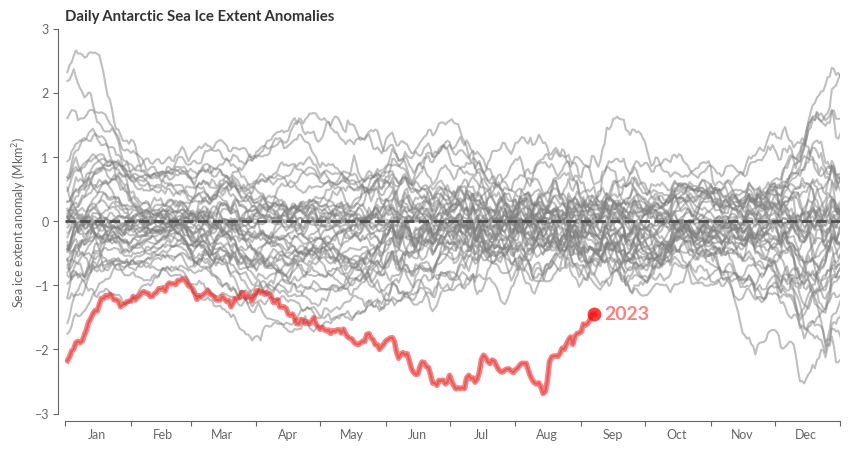

In [41]:
fig, ax = create_line_plot(sie_anomaly[region])
highlight_most_recent_year(ax, sie_anomaly[region])
center_labels_between_xticks(ax)
# Add center line
ax.axhline(0, color=".3", linewidth=0.5, ls='--', lw=2)
ax.set_xlim(0, 365)
ax.set_ylim(-3, 3)
ax.set_xlabel("")
ax.set_title(f"Daily {region} Sea Ice Extent Anomalies", weight="bold")
ax.set_ylabel("Sea ice extent anomaly (Mkm$^2$)")
sns.despine(ax=ax, trim=False, offset=5)
plt.show()


#### SIC concentration maps

In [27]:
sic_interp.coords

Coordinates:
  * time     (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-09-30T12:00:00
  * xc       (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc       (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03

In [28]:
sic_interp.coords.update({"xc": sic.xc * 1000, "yc": sic.yc * 1000})


In [52]:
sic_monthly = sic_interp.resample(time='1M').mean()

In [53]:
with ProgressBar():
    sic_monthly = sic_monthly.compute()

[########################################] | 100% Completed | 22.12 s


In [54]:
sic_monthly_clim = sic_monthly.sel(REF_PERIOD).groupby('time.month').mean('time')
sic_monthly_anomaly = sic_monthly.groupby('time.month') - sic_monthly_clim
sic_monthly_anomaly

<xarray.Dataset>
Dimensions:   (xc: 432, yc: 432, time: 525)
Coordinates:
  * xc        (xc) float64 -5.388e+06 -5.362e+06 ... 5.362e+06 5.388e+06
  * yc        (yc) float64 5.388e+06 5.362e+06 ... -5.362e+06 -5.388e+06
  * time      (time) datetime64[ns] 1979-01-31 1979-02-28 ... 2022-09-30
    month     (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 11 12 1 2 3 4 5 6 7 8 9
Data variables:
    ice_conc  (time, yc, xc) float64 0.0 0.0 0.0 0.0 0.0 ... nan nan nan nan nan

### Sea Ice Edge

In [9]:
def download_c3s_sea_ice_type(client, variable, year, month, save_to):
    """Download sea ice edge/type for a given year and month from the CDS."""

    client.retrieve(
        "satellite-sea-ice-edge-type",
        {
            "format": "tgz",
            "variable": [variable],  # one of ["sea_ice_edge", "sea_ice_type",],  
            "region": "northern_hemisphere",
            "cdr_type": ["cdr", "icdr"],
            "year": year,
            "month": month,
            "day": DAYS,
            "version": "2_0",
        },
        save_to
    )
    # Unzip and then remove zipped file
    path_dir = os.path.dirname(save_to)
    os.system(f"tar -xzf {save_to} --directory {path_dir}")
    os.system(f"rm {save_to}")


def download_loop(client, variable, years, months):
    for year in tqdm(years, desc="Overall progress"):
        for month in tqdm(months, desc="Year {}".format(year), leave=False):
            # Define the filename and the path to save the file
            filename = f"EUMETSAT_OSI_SAF_{year}_{month}.tar.gz"
            save_to = os.path.join(path_to[variable], filename)
            # Check if the extracted files already exist
            path_dir = os.path.dirname(save_to)
            file_name_pattern = os.path.join(path_dir, f"*{year}{month}*.nc")
            # Get all files in the directory that match the pattern
            files_in_dir = glob.glob(file_name_pattern)
            file_already_exists = len(files_in_dir) > 0
            # Download the file if it doesn't existEdge

In [ ]:
download_loop(client=client, variable='sea_ice_edge', years=YEARS, months=MONTHS)

In [60]:
with xr.open_dataset("data/edge/ice_edge_nh_ease2-125_cdr-v2p0_197902011200.nc") as ds:
    pass
ds

<xarray.Dataset>
Dimensions:                 (time: 1, nv: 2, xc: 864, yc: 864)
Coordinates:
  * time                    (time) datetime64[ns] 1979-02-01T12:00:00
  * xc                      (xc) float64 -5.394e+03 -5.381e+03 ... 5.394e+03
  * yc                      (yc) float64 5.394e+03 5.381e+03 ... -5.394e+03
    lat                     (yc, xc) float32 ...
    lon                     (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid  int32 ...
    time_bnds               (time, nv) datetime64[ns] ...
    ice_edge                (time, yc, xc) float32 ...
    uncertainty             (time, yc, xc) float32 ...
    status_flag             (time, yc, xc) float32 ...
Attributes: (12/43)
    title:                     Sea Ice Edge
    summary:                   Daily gridded Level-4 Sea Ice Edge Climate Dat...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  GCMDSK:Earth Science > Cryosphere > Sea Ice > ...
    keywords_vocabulary:       GCMDSK:GCMD Science Keywords:https://gcmd.eart...
    geospatial_lat_min:        16.62393
    ...                        ...
    processing_level:          Level-4 (l4)
    tracking_id:               7905b5d9-d8f8-4260-9edb-86bb27b88d8b
    doi:                       https://doi.org/10.24381/cds.29c46d83
    naming_authority:          no.met
    Conventions:               CF-1.7 ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (v36, 21 September 2016)

Again, the downloaded data set provides rich information about errors and uncertainties. However, we only consider the sea ice edge here, so we remove all additional variables that blow up the size of the data set.

In [61]:
def return_edge_only(ds):
    ds = ds.drop_vars(["lat", "lon"])
    return ds['ice_edge']

In [89]:
ice_edge = xr.open_mfdataset(path_to['ice_edge'] + "/*.nc", preprocess=return_edge_only)
ice_edge

<xarray.Dataset>
Dimensions:   (time: 3524, xc: 864, yc: 864)
Coordinates:
  * time      (time) datetime64[ns] 1979-02-01T12:00:00 ... 2022-09-30T12:00:00
  * xc        (xc) float64 -5.394e+03 -5.381e+03 ... 5.381e+03 5.394e+03
  * yc        (yc) float64 5.394e+03 5.381e+03 ... -5.381e+03 -5.394e+03
Data variables:
    ice_edge  (time, yc, xc) float32 dask.array<chunksize=(1, 864, 864), meta=np.ndarray>

In [91]:
ice_edge = ice_edge.chunk({'time': -1, 'xc': 50, 'yc': 50})
ice_edge.ice_edge

<xarray.DataArray 'ice_edge' (time: 3524, yc: 864, xc: 864)>
dask.array<rechunk-merge, shape=(3524, 864, 864), dtype=float32, chunksize=(3524, 50, 50), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1979-02-01T12:00:00 ... 2022-09-30T12:00:00
  * xc       (xc) float64 -5.394e+03 -5.381e+03 ... 5.381e+03 5.394e+03
  * yc       (yc) float64 5.394e+03 5.381e+03 ... -5.381e+03 -5.394e+03
Attributes:
    long_name:            Classification of sea surface into the classes of o...
    standard_name:        sea_ice_classification
    valid_min:            1
    valid_max:            3
    grid_mapping:         Lambert_Azimuthal_Grid
    flag_values:          [1 2 3]
    flag_meanings:        open_water open_ice closed_ice
    flag_descriptions:    flag 1: No ice or very open ice (less than 30% ice ...
    ancillary_variables:  uncertainty status_flag
    comment:              this field is the primary sea ice edge estimate for...

In [92]:
ice_edge_ref_period = ice_edge.sel(time=ice_edge.time.dt.month == 9).sel(REF_PERIOD)

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [93]:
median_ice_edge = ice_edge_ref_period.median('time')
with ProgressBar():
    median_ice_edge = median_ice_edge.compute()


[#####################################   ] | 92% Completed | 97.84 ss

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


[########################################] | 100% Completed | 168.45 s


In [96]:
median_ice_edge.coords.update({'xc': median_ice_edge.xc.values * 1000, 'yc': median_ice_edge.yc.values * 1000})

In [ ]:
edge_interp_monthly = edge_interp.resample(time='1M').mean()
edge_interp_monthly

In [ ]:
with ProgressBar():
    edge_interp_monthly = edge_interp_monthly.compute()[0].plot()

In [168]:
median_ice_edge = edge_interp_monthly.sel(time=slice('1991', '2020')).mean('time')
median_ice_edge.coords.update({'xc': median_ice_edge.xc.values * 1000, 'yc': median_ice_edge.yc.values * 1000})

In [97]:
def str2float(label):
    # Extract the numbers from the label
    number = ''.join(c for c in label if c.isdigit())
    number = float(number)
    # Longitude is negative if it is in the west of the meridian
    if 'W' in label:
        number = -number
    return number

def lon2rot(lon):
    rot_rad = lon
    if abs(lon) >= 90:
        rot_rad = lon - 180
    return rot_rad


def set_circle_boundary(ax):
    # Set a circle boundary for the map
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    ax.set_boundary(circle, transform=ax.transAxes)

def rotate_labels_polar_plot(ax, gridlines):
    # Rotate the labels to simplify reading them
    plt.draw()
    for label in ax.texts:
        alphanumeric_label = label.get_text()
        longitude = str2float(alphanumeric_label)
        if longitude in gridlines.xlocator.locs:
            rot_degree = lon2rot(longitude)
            label.set_rotation(rot_degree)
            label.set_horizontalalignment('center')
            label.set_verticalalignment('center')
            if abs(longitude) >= 90:
                label.set_verticalalignment('bottom')
            else:
                label.set_verticalalignment('top')
        else:
            label.set_visible(False)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


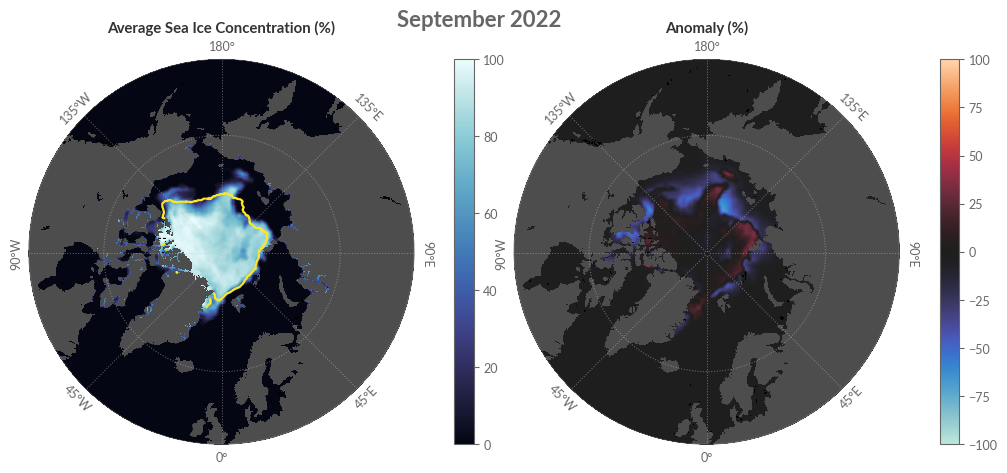

In [110]:


lon_formatter = LongitudeFormatter(
    number_format='.1f',
    degree_symbol='',
    dateline_direction_label=True
)
lat_formatter = LatitudeFormatter(
    number_format='.1f',
    degree_symbol=''
)

proj_polar = ccrs.NorthPolarStereo()
proj_data = ccrs.LambertAzimuthalEqualArea(central_longitude=0, central_latitude=90)

fig = plt.figure(figsize=(12, 5))
gs = GridSpec(1, 4, figure=fig, width_ratios=[1, .05, 1, .05])
ax1 = fig.add_subplot(gs[0, 0], projection=proj_polar)
ax2 = fig.add_subplot(gs[0, 2], projection=proj_polar)
cax1 = fig.add_subplot(gs[0, 1])
cax2 = fig.add_subplot(gs[0, 3])
axes = [ax1, ax2]
for ax in axes:
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

    gl = ax.gridlines(zorder=5, ls=':', lw=.75, color='.75', alpha=.5, draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-135, -90, -45, 0, 45, 90, 135, 180])
    gl.ylocator = mticker.FixedLocator([30, 65, 90])

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.add_feature(cfeature.OCEAN, zorder=1, color='k')
    ax.add_feature(cfeature.LAND, zorder=2, color='.3')

    set_circle_boundary(ax)

sic_cbar_kws = dict(label='')
sic_anom_cbar_kws = dict(label='')
sic_kws = dict(vmin=0, vmax=100, cmap=cmo.cm.ice, zorder=3, transform=proj_data, cbar_ax=cax1, cbar_kwargs=sic_cbar_kws)
sic_anom_kws = dict(vmin=-100, vmax=100, cmap='icefire', zorder=3, transform=proj_data, cbar_ax=cax2, cbar_kwargs=sic_anom_cbar_kws)
sic_monthly['ice_conc'].isel(time=-1).plot.pcolormesh(ax=ax1, **sic_kws)
sic_monthly_anomaly['ice_conc'].isel(time=-1).plot.pcolormesh(ax=ax2, **sic_anom_kws)

# Add the median ice edge as a yellow contour line
cp = median_ice_edge['ice_edge'].plot.contour(ax=ax1, levels=[2], transform=proj_data, zorder=5)
labels = ['1991-2020 median ice edge']

for ax in axes:
    ax.set_title('')
    # Rotate the labels to simplify reading them
    rotate_labels_polar_plot(ax, gl)

ax1.legend(loc='lower left', bbox_to_anchor=(-.05, -0.05), frameon=False)
ax1.set_title('Average Sea Ice Concentration (%)', weight='bold', loc='center')
ax2.set_title('Anomaly (%)', weight='bold', loc='center')
fig.suptitle('September 2022', weight='bold', fontsize=16)
plt.show()

In [127]:
sic_september = sic_monthly.sel(time=(sic_monthly.time.dt.month == 9))

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/xarray/core/accessor_dt.py:72: FutureWarning: Index.ravel returning ndarray is deprecated; in a future version this will return a view on self.
  values_as_series = pd.Series(values.ravel(), copy=False)


In [128]:
polyfit = sic_september.polyfit('time', 1)
polyfit

<xarray.Dataset>
Dimensions:                        (yc: 432, xc: 432, degree: 2)
Coordinates:
  * yc                             (yc) float64 5.388e+06 ... -5.388e+06
  * xc                             (xc) float64 -5.388e+06 ... 5.388e+06
  * degree                         (degree) int64 1 0
Data variables:
    ice_conc_polyfit_coefficients  (degree, yc, xc) float64 0.0 0.0 ... nan nan

In [129]:
trend = polyfit.ice_conc_polyfit_coefficients.sel(degree=1)
# Convert from 1/s to 1/decade
trend = (trend * 1.e9 * 60 * 60 * 24 * 365 * 10)

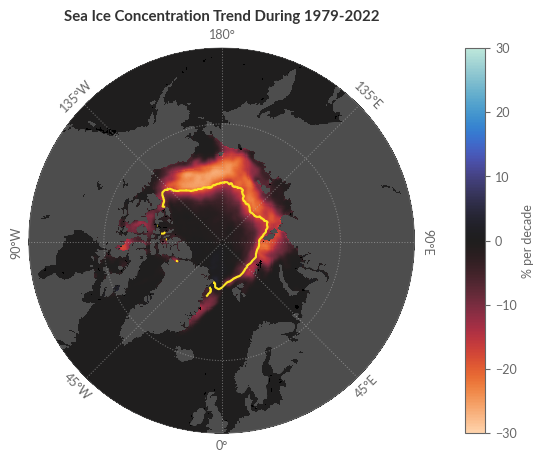

In [132]:
fig = plt.figure(figsize=(6, 5))
gs = GridSpec(1, 2, figure=fig, width_ratios=[1, .05])
ax1 = fig.add_subplot(gs[0, 0], projection=proj_polar)
cax1 = fig.add_subplot(gs[0, 1])
axes = [ax1]
for ax in axes:
    ax.set_extent([-180, 180, 50, 90], crs=ccrs.PlateCarree())

    gl = ax.gridlines(zorder=5, ls=':', lw=.75, color='.75', alpha=.5, draw_labels=True)
    gl.xlocator = mticker.FixedLocator([-135, -90, -45, 0, 45, 90, 135, 180])
    gl.ylocator = mticker.FixedLocator([30, 65, 90])

    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)

    ax.add_feature(cfeature.OCEAN, zorder=1, color='k')
    ax.add_feature(cfeature.LAND, zorder=2, color='.3')

    set_circle_boundary(ax)

bla_cbar_kws = dict(label='% per decade')
bla_kws = dict(vmin=-30, vmax=30, cmap='icefire_r', zorder=3, transform=proj_data, cbar_ax=cax1, cbar_kwargs=bla_cbar_kws)
trend.plot.pcolormesh(ax=ax1, **bla_kws)
cp = median_ice_edge["ice_edge"].plot.contour(ax=ax1, levels=[2], transform=proj_data, zorder=5)
labels = ['1991-2020 median ice edge']


for ax in axes:
    ax.set_title('')
    # Rotate the labels to simplify reading them
    rotate_labels_polar_plot(ax, gl)

ax1.set_title('Sea Ice Concentration Trend During 1979-2022', weight='bold', loc='center')
plt.show()

### Sea Ice Type
[CDS Data Access](https://cds.climate.copernicus.eu/cdsapp#!/dataset/satellite-sea-ice-edge-type?tab=overview)

<div class="alert alert-block alert-info">
<b>NOTE</b>: <br>
    As the time of writing, the Climate Data Store provides access to version 2 of the dataset and not the most recent version 3. If you need version 3, please consider downloading directly from <a href="https://osi-saf.eumetsat.int/products/osi-430-a">EUMETSAT OSI SAF official webpage</a>.
</div>

In [ ]:
MONTHS = ["{:02d}".format(m) for m in [1, 2, 3]]  # Note: only Jan-Mar are downloaded
download_loop(client=client, variable='sea_ice_type', years=YEARS, months=MONTHS)

In [134]:
with xr.open_dataset("data/type/ice_type_nh_ease2-250_cdr-v2p0_197902011200.nc") as ds:
    pass
ds

<xarray.Dataset>
Dimensions:                 (time: 1, nv: 2, xc: 432, yc: 432)
Coordinates:
  * time                    (time) datetime64[ns] 1979-02-01T12:00:00
  * xc                      (xc) float64 -5.388e+03 -5.362e+03 ... 5.388e+03
  * yc                      (yc) float64 5.388e+03 5.362e+03 ... -5.388e+03
    lat                     (yc, xc) float32 ...
    lon                     (yc, xc) float32 ...
Dimensions without coordinates: nv
Data variables:
    Lambert_Azimuthal_Grid  int32 ...
    time_bnds               (time, nv) datetime64[ns] ...
    ice_type                (time, yc, xc) float32 ...
    uncertainty             (time, yc, xc) float32 ...
    status_flag             (time, yc, xc) float32 ...
Attributes: (12/44)
    title:                     Sea Ice Type
    summary:                   Daily gridded Level-4 Sea Ice Type Climate Dat...
    comment:                   Northern Hemisphere sea ice type classificatio...
    topiccategory:             Oceans ClimatologyMeteorologyAtmosphere
    keywords:                  GCMDSK:Earth Science > Cryosphere > Sea Ice > ...
    keywords_vocabulary:       GCMDSK:GCMD Science Keywords:https://gcmd.eart...
    ...                        ...
    processing_level:          Level-4 (l4)
    tracking_id:               43552121-b502-4672-877e-4807b5f50fb5
    doi:                       https://doi.org/10.24381/cds.29c46d83
    naming_authority:          no.met
    Conventions:               CF-1.7 ACDD-1.3
    standard_name_vocabulary:  CF Standard Name Table (v36, 21 September 2016)

In [135]:
def return_type_only(ds):
    ds = ds.drop_vars(["lat", "lon"])
    return ds['ice_type']

In [136]:
ice_type = xr.open_mfdataset(path_to['ice_type'] + "/*.nc", preprocess=return_type_only)
ice_type

<xarray.Dataset>
Dimensions:   (time: 3376, xc: 432, yc: 432)
Coordinates:
  * time      (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-03-31T12:00:00
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
Data variables:
    ice_type  (time, yc, xc) float32 dask.array<chunksize=(1, 432, 432), meta=np.ndarray>

In [158]:
common_time_steps = sic.ice_conc.time.to_index().intersection(ice_type.ice_type.time.to_index())
sic_spring = sic["ice_conc"].sel(time=common_time_steps)
ice_type_spring = ice_type["ice_type"].sel(time=common_time_steps)

In [218]:
ice_area_spring = (sic_spring / 100 * 25**2)

In [219]:
is_seasonal_ice = ice_type_spring == 2
is_multiyear_ice = ice_type_spring == 3
is_ambiguous_ice = ice_type_spring == 4
ice_categories = xr.concat([is_seasonal_ice, is_multiyear_ice, is_ambiguous_ice], dim="ice_type")
ice_categories.coords.update({"ice_type": ["seasonal", "multiyear", "ambiguous"]})
ice_categories


<xarray.DataArray 'ice_type' (ice_type: 3, time: 2539, yc: 432, xc: 432)>
dask.array<concatenate, shape=(3, 2539, 432, 432), dtype=bool, chunksize=(1, 1, 432, 432), chunktype=numpy.ndarray>
Coordinates:
  * time      (time) datetime64[ns] 1979-01-02T12:00:00 ... 2022-03-31T12:00:00
  * xc        (xc) float64 -5.388e+03 -5.362e+03 ... 5.362e+03 5.388e+03
  * yc        (yc) float64 5.388e+03 5.362e+03 ... -5.362e+03 -5.388e+03
  * ice_type  (ice_type) <U9 'seasonal' 'multiyear' 'ambiguous'

Now, we compute the total sea ice extent by sea ice type. For this, we need the daily **sea ice area** per grid cell and the corresponding sea ice type. The sea ice area is obtained by multiplying grid cell areas by their corresponding sea ice concentration. Then we can sum up the sea ice area for each sea ice type and each day, which can be represented as a dot product over the spatial dimensions `xc` and `yc`:

In [220]:
average_ice_types = xr.dot(
    ice_area_spring.fillna(0),
    ice_categories,
    dims=['xc', 'yc']
)

Let's compute the `DataArray`:

In [221]:
with ProgressBar():
    average_ice_types = average_ice_types.compute()

[########################################] | 100% Completed | 89.43 s


Now, let's compute the average sea ice extent for each year by calculating the monthly average and then the mean over the months:

In [236]:
ice_extent_by_type = average_ice_types.resample(time='1M').mean()
ice_extent_by_type = ice_extent_by_type.groupby('time.year').mean('time')
ice_extent_by_type.name = 'ice_extent'

We convert the sea ice extent to million square kilometers:

In [237]:
ice_extent_by_type = ice_extent_by_type / 1.e6  # convert to Mkm^2

For visualising, we will bring the data into a form that is more convenient for plotting. For this, we will make use of `to_dateframe` method to convert the `sea_ice_extent` DataArray into a `pandas.DataFrame`:

In [290]:
ice_extent_df = ice_extent_by_type.to_dataframe().unstack('ice_type')['ice_extent']
rel_ice_extent_df = ice_extent_df.div(ice_extent_df.sum(axis=1), axis=0) * 100

In [353]:
most_recent_data = ice_type['ice_type'].sel(time=slice('2022-01-01', '2022-03-31')).median('time')
most_recent_data = most_recent_data.compute()
most_recent_data.coords.update({"xc": most_recent_data.xc.values * 1000, "yc": most_recent_data.yc.values * 1000})

/home/nrieger/miniconda3/envs/tutorial/lib/python3.10/site-packages/dask/utils.py:73: RuntimeWarning: All-NaN slice encountered
  return func(*args, **kwargs)


In [385]:
color_cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
colors = sns.color_palette("tab10", n_colors=5)

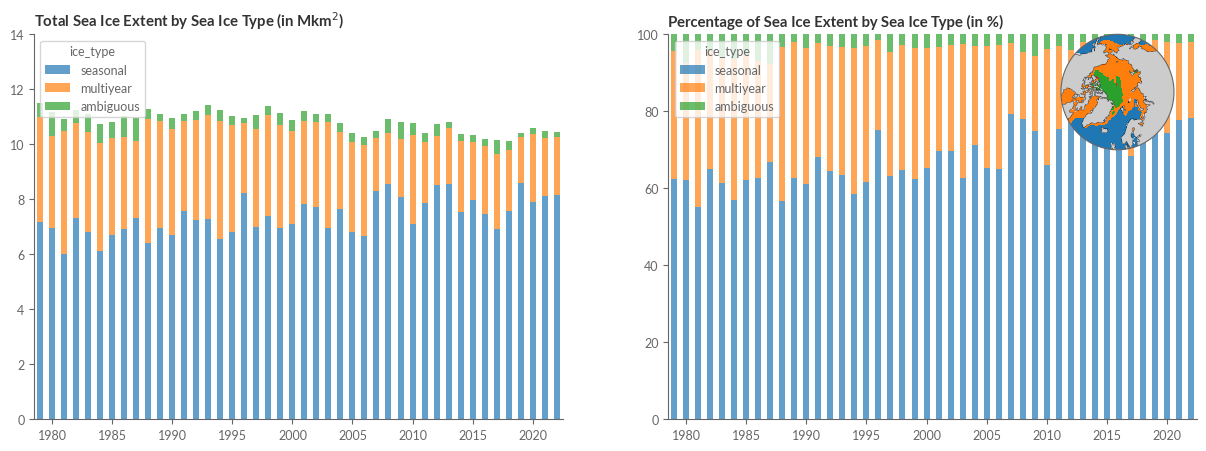

In [399]:
pad  = 0.0
w = 0.3
h = 0.3
n_years = ice_extent_df.shape[0]
xticks = np.arange(1, n_years, 5)
xticklabels = ice_extent_df.index[xticks]
fig = plt.figure(figsize=(15, 5))
ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122)
ice_extent_df.plot.bar(ax=ax1, stacked=True, xticks=xticks, color=colors, alpha=.7)
rel_ice_extent_df.plot.bar(ax=ax2, stacked=True, xticks=xticks, color=colors, alpha=.7)
for ax in [ax1, ax2]:
    ax.set_xticklabels(xticklabels, rotation=0)
    ax.set_xlabel('')
    ax.set_ylabel('Ice extent (Mkm$^2$)')
    sns.move_legend(ax, "upper left")

ax1.set_ylim(0, 14)
ax2.set_ylim(0, 100)

ax1.set_title('Total Sea Ice Extent by Sea Ice Type (in Mkm$^2$)', weight='bold')
ax2.set_title('Percentage of Sea Ice Extent by Sea Ice Type (in %)', weight='bold')

ax1.set_ylabel('')
ax2.set_ylabel('')

# Add a mini map of the Arctic to the upper right corner
a = ax2.get_position()
axins = fig.add_axes([a.x1-(w+pad)*a.width,a.y1-(h+pad)*a.height,w*a.width,h*a.height], projection=proj_polar)
axins.add_feature(cfeature.LAND, zorder=1, color='.8')
axins.coastlines('110m', lw=.25)
axins.set_extent([-180, 180, 55, 90], crs=ccrs.PlateCarree())
most_recent_data.plot.contourf(ax=axins, transform=proj_data, add_colorbar=False, levels=[1.5, 2.5, 3.5], colors=colors)
set_circle_boundary(axins)